In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
#!ls '../input/cityofla/CityofLA/Job Bulletins'

In [73]:
import re
import numpy as np
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize

def load_jobopening_dataset():

    data_path = '../input/cityofla/CityofLA/Job Bulletins'
    seed = 123
    # Load the data
    texts = []
    positions = []
    content_array=[]
    for fname in sorted(os.listdir(data_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(data_path, fname),"rb") as f:
                texts.append(str(f.read()))
                positions.append((re.split(' (?=class)', fname))[0])
        
    print(len(texts))
    print(len(positions))

    return (texts,positions)

In [74]:
job_data, positions = load_jobopening_dataset()

683
683


In [75]:
job_data[0].replace("\\r\\n"," ").replace("\\\'s","")
#.split("b'")[1]

'b\'311 DIRECTOR Class Code:       9206 Open Date:  04-18-14 ANNUAL SALARY   $125,175 to $155,514   DUTIES  A 311 Director is responsible for the successful operation and expansion of the 311 Call Center in the Information Technology Agency (ITA) which answers call from constituents regarding Citywide services provided by City departments; works to ensure the efficient and effective resolution of any issues that may arise; plans, directs, hires, coaches, and coordinates a large staff of professional, technical and clerical employees engaged in the implementation, administration, and operations of the City 311 Call Center; applies sound supervisor principles and techniques in building and maintaining and effective work force; fulfills equal opportunity responsibilities; and does related work.  REQUIREMENTS  1. One year of full-time paid experience as a Senior Management Analyst with the City of Los Angeles or in a class which is at least at the level which provides professional experien

In [76]:


exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['city','los','angele','angeles']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

lemma = WordNetLemmatizer()
porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    doc = doc.replace("\\r\\n"," ").replace("\\\'s","").replace("\t"," ") #.split("b'")[1]
    #doc = re.sub(r'([t])\1+', '', doc, re.I)
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    #apply Lemmatization
    #normalized = " ".join(lemma.lemmatize(word) for word in filtered_tokens)
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [77]:
norm_positions=[]
for text_sample in positions:
    norm_positions.append(normalize_document(text_sample))

In [78]:
norm_corpus=[]
for text_sample in job_data:
    norm_corpus.append(normalize_document(text_sample))

In [79]:
norm_positions[0]

'director'

In [80]:
norm_corpus[0]

'director class code open date annual salary duties director responsible successful operation expansion call center information technology agency ita answers call constituents regarding citywide services provided departments works ensure efficient effective resolution issues may arise plans directs hires coaches coordinates large staff professional technical clerical employees engaged implementation administration operations call center applies sound supervisor principles techniques building maintaining effective work force fulfills equal opportunity responsibilities related work requirements one year fulltime paid experience senior management analyst class least level provides professional experience supervisory managerial work relating call center least call agents call center receives least one million calls annually bachelor degree recognized college university four years fulltime paid experience call center environment least call agents call center receives least one million calls

In [ ]:
#job_positions=[]
#for i in range(len(norm_corpus)):
#    text = norm_corpus[i]
#    text = text.replace("tclass","class")
#    text = text.replace("ttclass","class")
#    text = re.sub(r'(.)\1{2,}', '', text, re.I) #r'([t])\1+'
#    res = re.split(' (?=class)', text)
#    print(res[0])

In [ ]:
#len(job_positions)

In [63]:
def get_num_words_per_sample(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [64]:
print(get_num_words_per_sample(norm_corpus))

744.0


In [81]:
import matplotlib.pyplot as plt
def plot_sample_length_distribution(sample_texts):
    plt.hist([len(s.split()) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

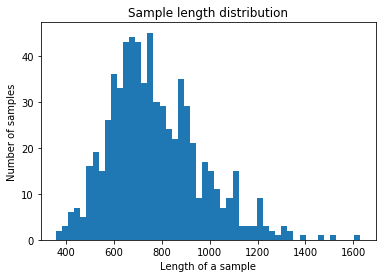

In [66]:
plot_sample_length_distribution(norm_corpus)

In [82]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 3),
                                          num_ngrams=30):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]#num_ngrams

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(30,20)) 
    plt.bar(idx, counts, width=0.6, color='b')
    plt.xlabel('N-grams',fontsize="18")
    plt.ylabel('Frequencies',fontsize="18")
    plt.title('Frequency distribution of n-grams',fontsize="36")
    plt.xticks(idx, ngrams, rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()


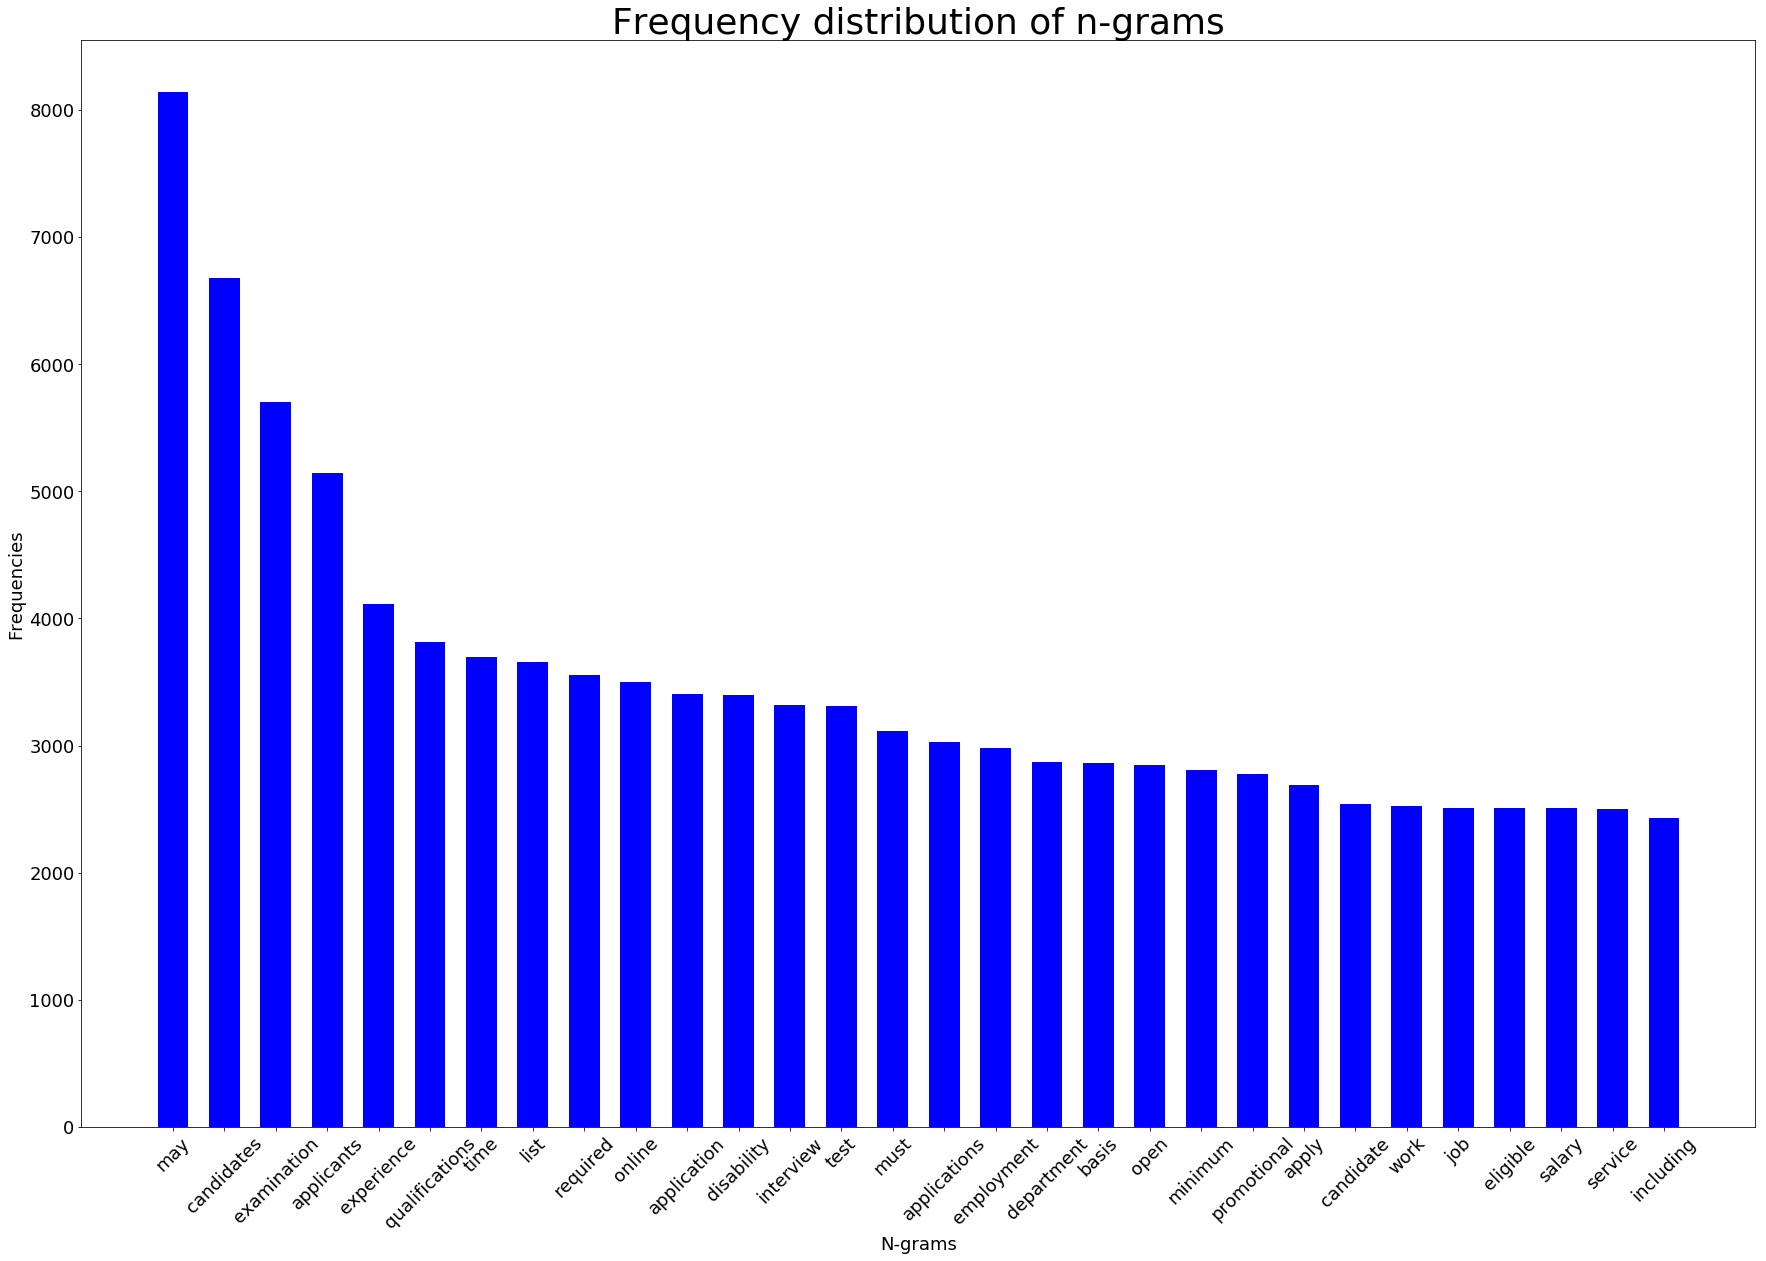

In [83]:
plot_frequency_distribution_of_ngrams(norm_corpus)

**Observation here is : the words 'may', 'candidates', 'examination' , 'applicants' are occurring too many times. This probably will make the job ad very very formal, and scare away applicants.**********

**The good point is that the word 'disability' is making in the top 20 most frequent words, which means the job ads are inclusive.**

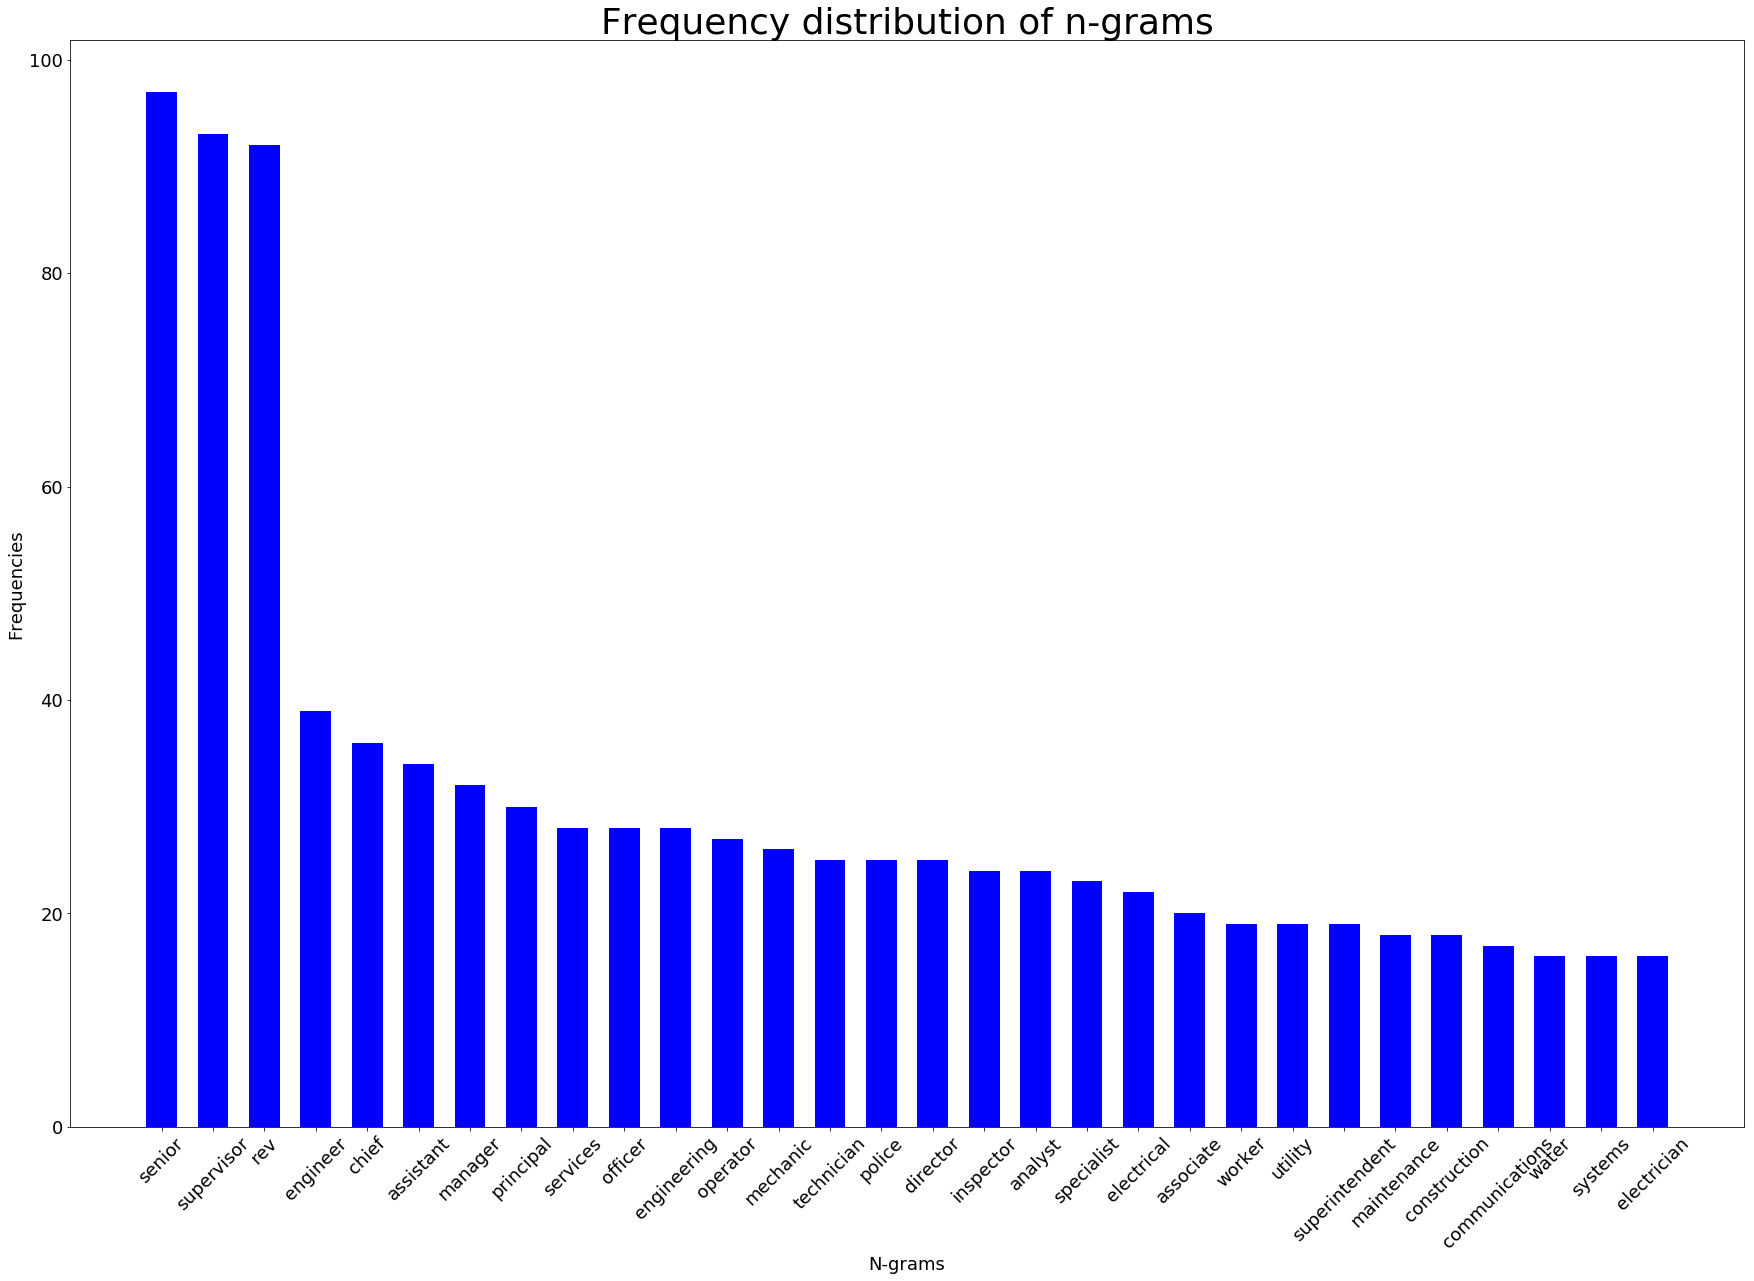

In [84]:
plot_frequency_distribution_of_ngrams(norm_positions)

**Shows Supervisor jobs, chief jobs, officer, engineering, inspector are most prevalent, followed by electrician, analyst,associate**

**Some issues are use of terms like worker, operator , maybe these can be changed for better reach**

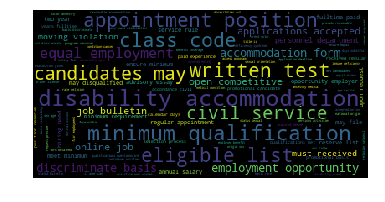

In [71]:
full_norm_corpus=' '.join(norm_corpus)

from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud().generate(full_norm_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Some words that might scare off applicants are : written test**

**Good points : equal employer, disability**

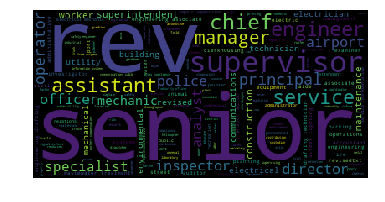

In [72]:
full_norm_corpus=' '.join(norm_positions)

from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud().generate(full_norm_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()